In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Modelo de subasta

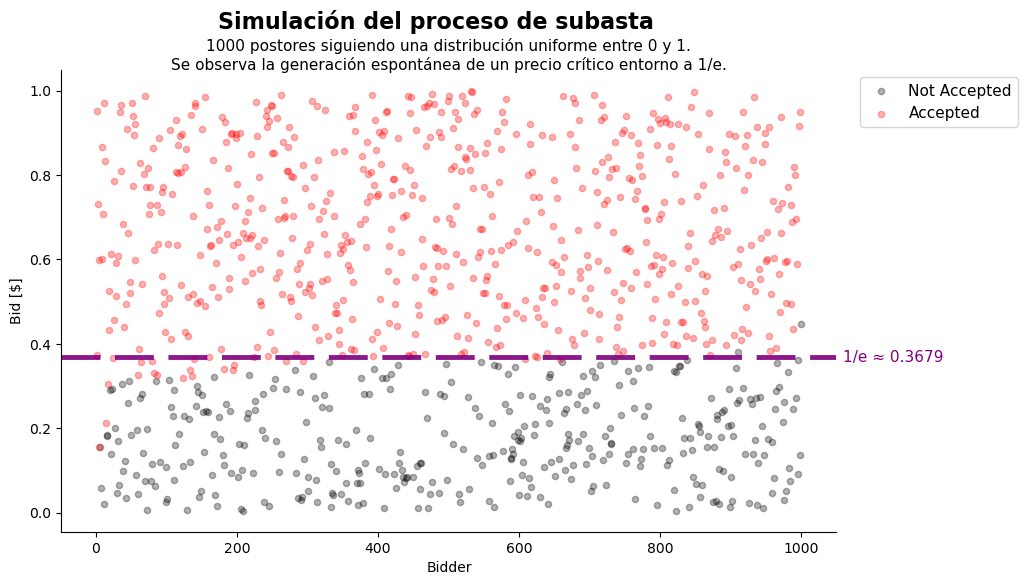

In [5]:
# Set a seed for reproducibility
np.random.seed(42)

# Parameters from the paper's simulation (Fig. 1A)
N = 1000
mu = 0
sigma = 0.3

# Generate a sequence of 1000 bids from a Log-Normal distribution
bids = np.random.uniform(0, 1, N)

# Initialize lists to store accepted and non-accepted bids
accepted_bids = []
non_accepted_bids = []
accepted_bid_indices = []
non_accepted_bid_indices = []
pending_bids = []

# Implement the auction mechanism from the paper
for i, new_bid in enumerate(bids):
    bid_index = i + 1

    # If there are no pending bids, the new bid is just added to the pending queue
    if not pending_bids:
        pending_bids.append(new_bid)
        continue

    # Find the maximum value among the pending bids
    max_pending_bid = max(pending_bids)

    # Apply the selling rule:
    if new_bid < max_pending_bid:
        # A sale occurs. Find the index of the accepted bid
        accepted_bid_index = np.where(bids == max_pending_bid)[0][0] + 1
        accepted_bids.append(max_pending_bid)
        accepted_bid_indices.append(accepted_bid_index)
        
        # The accepted bid is removed from the pending list
        pending_bids.remove(max_pending_bid)
        
        # The current bid is not accepted at this time and becomes a new pending bid
        non_accepted_bids.append(new_bid)
        non_accepted_bid_indices.append(bid_index)
        pending_bids.append(new_bid)
    else:
        # No sale occurs, the new bid is added to the pending list
        pending_bids.append(new_bid)
        non_accepted_bids.append(new_bid)
        non_accepted_bid_indices.append(bid_index)

# After the loop, any remaining bids are "frozen" and not accepted
for bid in pending_bids:
    non_accepted_bids.append(bid)
    non_accepted_bid_indices.append(np.where(bids == bid)[0][0] + 1)
    
# Get the indices and values for plotting
accepted_indices_plot = [i for i, b in enumerate(bids) if b in accepted_bids]
non_accepted_indices_plot = [i for i, b in enumerate(bids) if b not in accepted_bids]

accepted_values_plot = [bids[i] for i in accepted_indices_plot]
non_accepted_values_plot = [bids[i] for i in non_accepted_indices_plot]

accepted_indices_plot = [i + 1 for i in accepted_indices_plot]
non_accepted_indices_plot = [i + 1 for i in non_accepted_indices_plot]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Configurar el estilo del gráfico
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.scatter(non_accepted_indices_plot, non_accepted_values_plot, c='black', label='Not Accepted', s=20, alpha=0.3)
plt.scatter(accepted_indices_plot, accepted_values_plot, c='red', label='Accepted', s=20, alpha=0.3)

# Add critical price line based on the paper's value
critical_price = 1/np.e
plt.axhline(y=critical_price, color='#800080', linestyle=':', linewidth=3.5, 
            dashes=(8, 3), alpha=0.9)
# Agregar texto al lado de la línea
plt.text(1060, critical_price, f'1/e ≈ {round(critical_price, 4)}', 
         color='#800080', fontsize=11, verticalalignment='center')

plt.suptitle('Simulación del proceso de subasta', 
           fontsize=16, fontweight='bold', y=0.98)
plt.title('1000 postores siguiendo una distribución uniforme entre 0 y 1.\n' +
         'Se observa la generación espontánea de un precio crítico entorno a 1/e.',
         pad=20, fontsize=11,y=0.94)
plt.xlabel('Bidder')
plt.ylabel('Bid [$]')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)

plt.show()
#plt.savefig('auction_scatter_plot.png')
#print("Plot saved to auction_scatter_plot.png")

## Análisis de Avalanchas de Ventas

Una avalancha de ventas se puede entender como una secuencia de ventas que ocurren de forma consecutiva. Por ejemplo, si tenemos seis ventas que ocurren en los momentos $[2, 3, 4, 10, 11, 20]$, entonces se pueden identificar tres avalanchas de tamaño $3$ (correspondiente a las ventas $[2, 3, 4]$), tamaño $2$ (correspondiente a las ventas $[10, 11]$) y $1$ (correspondiente a la última venta).

Para este análisis simulamos múltiples subastas con distribución uniforme $[0,1]$, detectando secuencias consecutivas de ventas (avalanchas). Evaluamos tanto el tamaño de las avalanchas que ocurren, para identificar patrones, como la criticidad del fenómeno.

In [6]:
def simulate_basic_auction(N):
    """Simulación básica de subasta (modelo original)"""
    bids = np.random.uniform(0, 1, N)
    pending_bids = []
    sales = []  # Lista de índices donde ocurren ventas
    
    for i, new_bid in enumerate(bids):
        if not pending_bids:
            pending_bids.append((new_bid, i))
            continue
        
        # Encontrar el máximo entre las ofertas pendientes
        max_bid, max_index = max(pending_bids, key=lambda x: x[0])
        
        # Regla de venta: si la nueva oferta es menor que el máximo
        if new_bid < max_bid:
            sales.append(i)  # Registrar que hubo una venta en el paso i
            pending_bids.remove((max_bid, max_index))
        
        pending_bids.append((new_bid, i))
    
    return sales

def detect_avalanches(sales):
    """
    Detecta avalanchas de ventas consecutivas
    
    Args:
        sales: Lista de índices donde ocurrieron ventas
        
    Returns:
        list: Lista de tamaños de avalanchas
    """
    if not sales:
        return []
    
    avalanches = []
    current_avalanche_size = 1
    
    for i in range(1, len(sales)):
        # Si la venta actual es consecutiva a la anterior
        if sales[i] - sales[i-1] == 1:
            current_avalanche_size += 1
        else:
            # Fin de la avalancha actual
            avalanches.append(current_avalanche_size)
            current_avalanche_size = 1
    
    # Agregar la última avalancha
    avalanches.append(current_avalanche_size)
    
    return avalanches

def analyze_sales_avalanches(N=10000, num_simulations=100):
    """
    Analiza la distribución de avalanchas de ventas en el modelo de subasta.
    Una avalancha se define como una secuencia consecutiva de ventas.
    
    Args:
        N: Número de postores por simulación
        num_simulations: Número de simulaciones independientes
    
    Returns:
        dict: Resultados del análisis incluyendo tamaños de avalanchas y estadísticas
    """
    # Ejecutar múltiples simulaciones
    all_avalanches = []
    all_sales_counts = []
    
    print(f"Ejecutando {num_simulations} simulaciones con {N} postores cada una...")
    
    for sim in range(num_simulations):
        if sim % 20 == 0:
            print(f"Simulación {sim+1}/{num_simulations}")
        
        sales = simulate_basic_auction(N)
        avalanches = detect_avalanches(sales)
        
        all_avalanches.extend(avalanches)
        all_sales_counts.append(len(sales))
    
    return {
        'avalanche_sizes': all_avalanches,
        'sales_counts': all_sales_counts,
        'total_avalanches': len(all_avalanches),
        'total_sales': sum(all_sales_counts)
    }

In [7]:
# Ejecutamos el análsis de avalanchas
results = analyze_sales_avalanches(N=5000, num_simulations=50)

# Contamos la frecuencia de cada tamaño de avalancha
size_counts = Counter(results['avalanche_sizes'])
sizes = sorted(size_counts.keys())
frequencies = [size_counts[s] for s in sizes]

Ejecutando 50 simulaciones con 5000 postores cada una...
Simulación 1/50
Simulación 21/50
Simulación 21/50
Simulación 41/50
Simulación 41/50


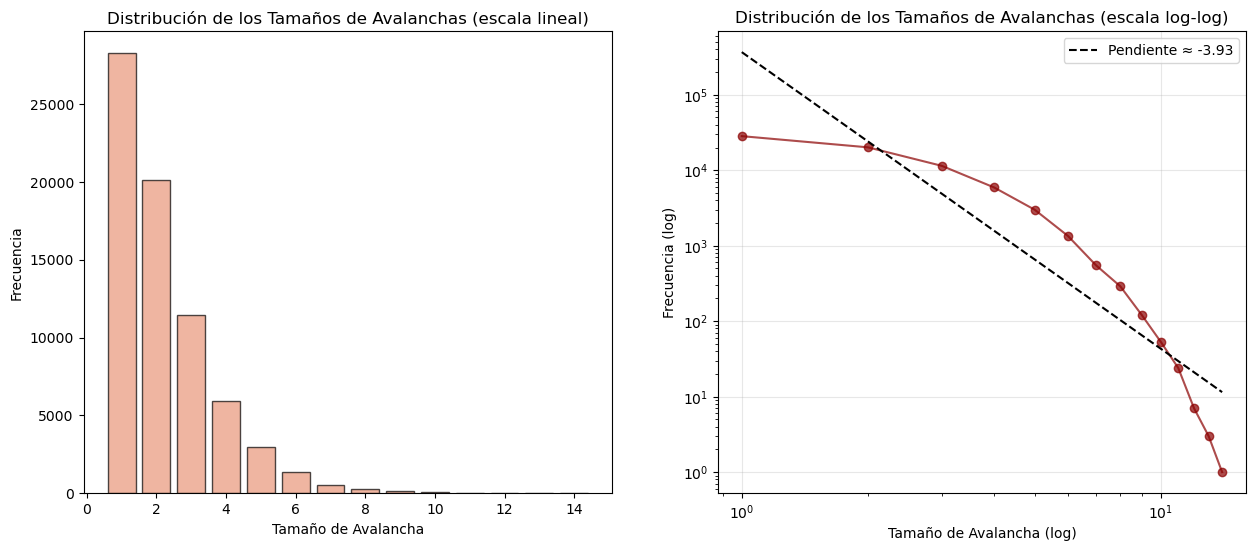

In [10]:
# Crear figura con múltiples subplots
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
axes = axes.flatten()

# Miramos la distribución de los tamaños de avalancha (escala lineal)
axes[0].bar(sizes, frequencies, alpha=0.7, color='darksalmon', edgecolor='black')
axes[0].set_xlabel('Tamaño de Avalancha')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de los Tamaños de Avalanchas (escala lineal)')
#axes[0].grid(True, alpha=0.3)

# Miramos la distribución en escala log-log para verificar ley de potencias
axes[1].loglog(sizes, frequencies, 'o-', color='darkred', alpha=0.7)
axes[1].set_xlabel('Tamaño de Avalancha (log)')
axes[1].set_ylabel('Frecuencia (log)')
axes[1].set_title('Distribución de los Tamaños de Avalanchas (escala log-log)')
axes[1].grid(True, alpha=0.3)

# Agregamos una línea de tendencia
if len(sizes) > 1:
    # Convertimos los valores a logaritmos
    log_sizes = np.log10(sizes)
    log_freqs = np.log10(frequencies)

    # Si tenemos valores menores o iguales a cero en `sizes` o `frequences`, al aplicar logaritmos nos devuelve
    # valores NaN. Los filtramos para no tener errores.
    valid_idx = np.isfinite(log_sizes) & np.isfinite(log_freqs)

    if np.sum(valid_idx) > 1:
        # Ajustamos la línea de tendencia
        coeffs = np.polyfit(log_sizes[valid_idx], log_freqs[valid_idx], 1)
        fit_line = np.poly1d(coeffs)

        # Incluímos la línea de tendencia en el gráfico
        axes[1].plot(sizes, 10 ** (fit_line(log_sizes)), '--', color='black', label=f'Pendiente ≈ {coeffs[0]:.2f}')
        axes[1].legend()

# Modelo de Luckock

En este modelo que intenta simular el mercado de compra y venta de instrumentos financieros. Puntualmente, utiliza dos distribuciones Uniforme para modelar las Ordenes de compra y venta.

La regla que sigue el modelo es sencilla: **Solo se ejecuta una orden de venta si existe una orden de compra mayor o igual a la ordend de venta**

En otras palabras, el comprador está dispuesto a pagar X y si el vendedor quiere recibir Y, solo se ejecuta si X >= Y.


Lo que termina de mostrar este modelo es un precio crítico en alrededor de 0.32, generando que todas las ordenes de compra menores a 0.32 se acumulen (no se vendan) y que todas las órdenes de venta mayores a 0.68 (1-0.32), se acumulan también.

Simulación completada. Órdenes persistentes:
Compra: 986
Venta: 986
Rango órdenes compra: [0.000, 0.505]
Rango órdenes venta: [0.516, 1.000]


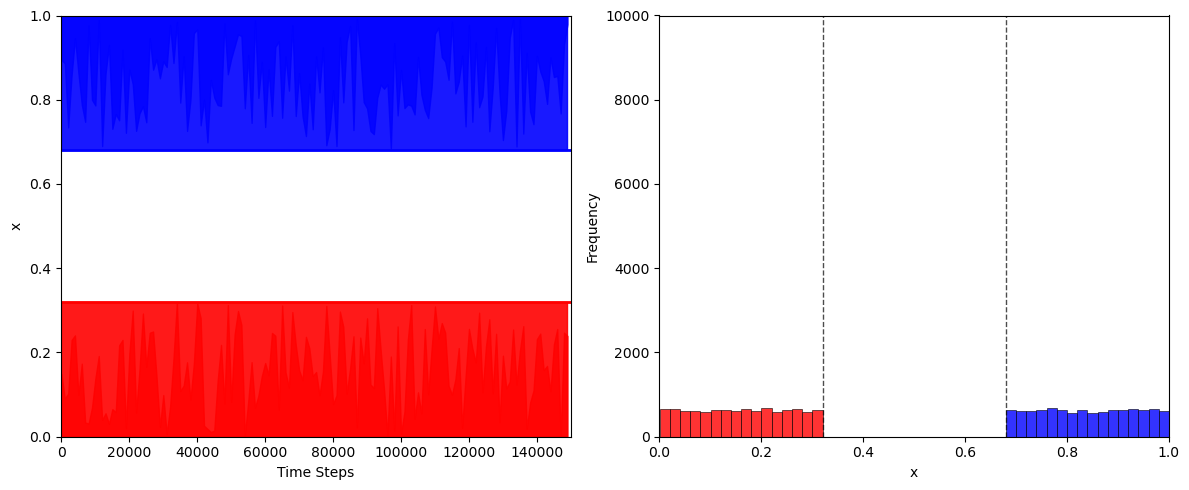

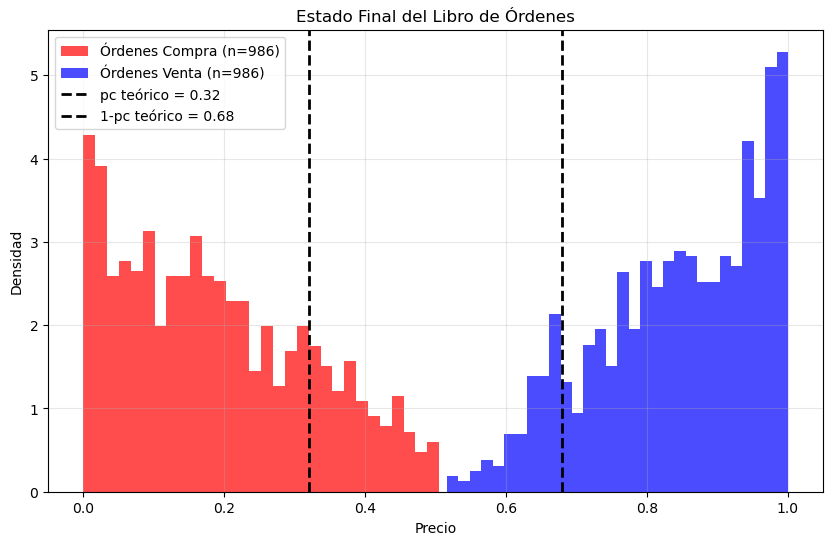

In [11]:
# Parámetros del modelo de Order Book de Luckock
N_steps = 200000  # Número de pasos para alcanzar estado estacionario
pc_teorico = 0.32  # Valor crítico teórico

# Inicialización
buy_orders = []   # Órdenes de compra que persisten
sell_orders = []  # Órdenes de venta que persisten
all_orders_history = []  # Historia de todas las órdenes generadas

# Simulación
for step in range(N_steps):
    # Generar nueva orden de compra y venta
    X = np.random.uniform(0, 1)  # Precio de orden de compra
    Y = np.random.uniform(0, 1)  # Precio de orden de venta
    
    all_orders_history.append(('buy', X))
    all_orders_history.append(('sell', Y))
    
    # Revisar si la orden de compra puede ejecutarse
    can_execute_buy = False
    for sell_price in sell_orders:
        if X >= sell_price:  # Hay match
            can_execute_buy = True
            sell_orders.remove(sell_price)
            break
    
    if not can_execute_buy:
        buy_orders.append(X)
    
    # Revisar si la orden de venta puede ejecutarse
    can_execute_sell = False
    for i, buy_price in enumerate(buy_orders):
        if Y <= buy_price:  # Hay match
            can_execute_sell = True
            buy_orders.remove(buy_price)
            break
    
    if not can_execute_sell:
        sell_orders.append(Y)
    
    # Control de memoria: mantener solo las últimas órdenes
    if len(buy_orders) > 1000:
        buy_orders = buy_orders[-1000:]
    if len(sell_orders) > 1000:
        sell_orders = sell_orders[-1000:]

# Preparar datos para los gráficos
print(f"Simulación completada. Órdenes persistentes:")
print(f"Compra: {len(buy_orders)}")
print(f"Venta: {len(sell_orders)}")

if len(buy_orders) > 0:
    print(f"Rango órdenes compra: [{min(buy_orders):.3f}, {max(buy_orders):.3f}]")
if len(sell_orders) > 0:
    print(f"Rango órdenes venta: [{min(sell_orders):.3f}, {max(sell_orders):.3f}]")

# Crear la visualización exacta como en la imagen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Evolución temporal (como series de tiempo)
# Simular la evolución mostrando las regiones donde se acumulan las órdenes
steps_show = np.arange(0, 150000, 1000)
buy_region = []
sell_region = []

for step in steps_show:
    # Las órdenes de compra se acumulan en [0, pc]
    buy_region.append(np.random.uniform(0, pc_teorico))
    # Las órdenes de venta se acumulan en [1-pc, 1]
    sell_region.append(np.random.uniform(1-pc_teorico, 1.0))

# Gráfico de evolución temporal
ax1.fill_between(steps_show, 0, buy_region, color='red', alpha=0.8, label='Órdenes Compra')
ax1.fill_between(steps_show, sell_region, 1.0, color='blue', alpha=0.8, label='Órdenes Venta')
ax1.axhline(y=pc_teorico, color='red', linestyle='-', linewidth=2)
ax1.axhline(y=1-pc_teorico, color='blue', linestyle='-', linewidth=2)

# Mostrar las regiones claramente
ax1.fill_between(steps_show, 0, pc_teorico, color='red', alpha=0.9)
ax1.fill_between(steps_show, 1-pc_teorico, 1.0, color='blue', alpha=0.9)

ax1.set_xlim(0, 150000)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x')
ax1.grid(False)

# Gráfico 2: Histograma de frecuencias
# Crear histograma que muestre la distribución bimodal característica
x_values = []
frequencies = []

# Región de órdenes de compra [0, pc]
buy_hist = np.random.uniform(0, pc_teorico, 10000)
x_values.extend(buy_hist)

# Gap sin órdenes [pc, 1-pc]
# (no agregamos valores aquí)

# Región de órdenes de venta [1-pc, 1]
sell_hist = np.random.uniform(1-pc_teorico, 1.0, 10000)
x_values.extend(sell_hist)

# Crear el histograma
counts, bins, patches = ax2.hist(x_values, bins=50, color='black', alpha=0.8, 
                                edgecolor='black', linewidth=0.5)

# Colorear las regiones apropiadamente
for i, (patch, bin_center) in enumerate(zip(patches, (bins[:-1] + bins[1:]) / 2)):
    if bin_center <= pc_teorico:
        patch.set_facecolor('red')
    elif bin_center >= 1 - pc_teorico:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('white')  # Gap

ax2.set_xlim(0, 1)
ax2.set_xlabel('x')
ax2.set_ylabel('Frequency')
ax2.set_ylim(0, 10000)

# Agregar líneas verticales para marcar pc y 1-pc
ax2.axvline(x=pc_teorico, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax2.axvline(x=1-pc_teorico, color='black', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.show()


# Crear gráfico adicional mostrando el estado actual del libro
fig2, ax3 = plt.subplots(1, 1, figsize=(10, 6))

if len(buy_orders) > 0:
    ax3.hist(buy_orders, bins=30, alpha=0.7, color='red', 
            label=f'Órdenes Compra (n={len(buy_orders)})', density=True)
if len(sell_orders) > 0:
    ax3.hist(sell_orders, bins=30, alpha=0.7, color='blue', 
            label=f'Órdenes Venta (n={len(sell_orders)})', density=True)

ax3.axvline(x=pc_teorico, color='black', linestyle='--', linewidth=2, 
           label=f'pc teórico = {pc_teorico}')
ax3.axvline(x=1-pc_teorico, color='black', linestyle='--', linewidth=2, 
           label=f'1-pc teórico = {1-pc_teorico:.2f}')

ax3.set_xlabel('Precio')
ax3.set_ylabel('Densidad')
ax3.set_title('Estado Final del Libro de Órdenes')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.show()
